In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import matlab.engine

In [2]:
df = pd.read_csv("model_data")
df.head()

,Time,EacToday(kWh),INVTemp(℃),AMTemp1(℃),BTTemp(℃),OUTTemp(℃),AMTemp2(℃),next_after
0,2025-03-01 06:52:01,0.0,25.3,23.9,32.3,0,23.2,NaN
1,2025-03-01 06:57:01,0.0,26.5,25.4,33.1,0,23.5,98.5
2,2025-03-01 07:02:01,0.0,27.6,27.1,34.0,0,23.9,301.0
3,2025-03-01 07:07:01,0.0,28.8,28.6,35.2,0,24.0,297.5
4,2025-03-01 07:12:01,0.0,29.8,30.0,36.0,0,24.2,302.5


In [3]:
df["Time"]=pd.to_datetime(df["Time"])
# Set Time as index
df.set_index('Time', inplace=True)

In [4]:
# Resample the data at a regular interval (e.g., every 5 minutes)
# We'll use 'nearest' to handle irregular intervals by aligning to the closest time in the target interval.
df_resampled = df.resample('5T').mean()  # '5T' means 5-minute intervals

# Perform linear interpolation for missing values after resampling
df_resampled = df_resampled.interpolate(method='linear')

# If there are still missing values after interpolation (i.e., at the edges), fill them
df_resampled.fillna(method='bfill', inplace=True)
df_resampled.fillna(method='ffill', inplace=True)


In [6]:
df_resampled.head(10)

,EacToday(kWh),INVTemp(℃),AMTemp1(℃),BTTemp(℃),OUTTemp(℃),AMTemp2(℃),next_after
Time,,,,,,,
2025-03-01 06:50:00,0.0,25.3,23.9,32.3,0.0,23.2,98.5
2025-03-01 06:55:00,0.0,26.5,25.4,33.1,0.0,23.5,98.5
2025-03-01 07:00:00,0.0,27.6,27.1,34.0,0.0,23.9,301.0
2025-03-01 07:05:00,0.0,28.8,28.6,35.2,0.0,24.0,297.5
2025-03-01 07:10:00,0.0,29.8,30.0,36.0,0.0,24.2,302.5
2025-03-01 07:15:00,0.1,30.7,31.2,37.1,0.0,24.4,296.5
2025-03-01 07:20:00,0.2,31.6,31.8,38.3,0.0,24.6,302.5
2025-03-01 07:25:00,0.4,32.6,32.5,39.1,0.0,24.9,299.5
2025-03-01 07:30:00,0.6,33.7,33.2,40.5,0.0,25.2,297.0


In [3]:
# df = df.dropna()
# df = df.drop('OUTTemp(℃)', axis=1)
# df["Time"]=pd.to_datetime(df["Time"])

In [18]:
df_resampled.shape

(8789, 7)

In [19]:
inputs = df_resampled.drop(['EacToday(kWh)','next_after'],axis=1)
output = df_resampled['EacToday(kWh)']

In [20]:
inputs = inputs.clip(lower=inputs.quantile(0.01), upper=inputs.quantile(0.99), axis=1)

In [21]:
# Normalize data (optional but good for system identification)
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

u_scaled = scaler_x.fit_transform(inputs)
y_scaled = scaler_y.fit_transform(output.values.reshape(-1, 1))


In [22]:
eng = matlab.engine.start_matlab()

# Convert NumPy arrays to MATLAB types
u_mat = matlab.double(u_scaled.tolist())
y_mat = matlab.double(y_scaled.tolist())

In [23]:
eng.workspace['u'] = u_mat
eng.workspace['y'] = y_mat
eng.eval("data = iddata(y, u, 300);", nargout=0)  # sample time = 1
eng.eval("sys = n4sid(data, 4);", nargout=0)    # 4 is system order, can be tuned

In [24]:
# Step 4: Predict output
eng.eval("yp = sim(sys, data);", nargout=0)
eng.eval("y_pred = yp.OutputData;", nargout=0)
y_pred_scaled = eng.workspace['y_pred']
y_pred_np = np.array(y_pred_scaled).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()

In [25]:
# Step 5: Compare actual vs predicted
actual = output.values
mse = mean_squared_error(actual, y_pred_inv)
r2 = r2_score(actual, y_pred_inv)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 2010.00
R² Score: 0.94


In [26]:
print(f"NaNs in actual: {np.isnan(actual).sum()}")
print(f"NaNs in y_pred_inv: {np.isnan(y_pred_inv).sum()}")

NaNs in actual: 0
NaNs in y_pred_inv: 0


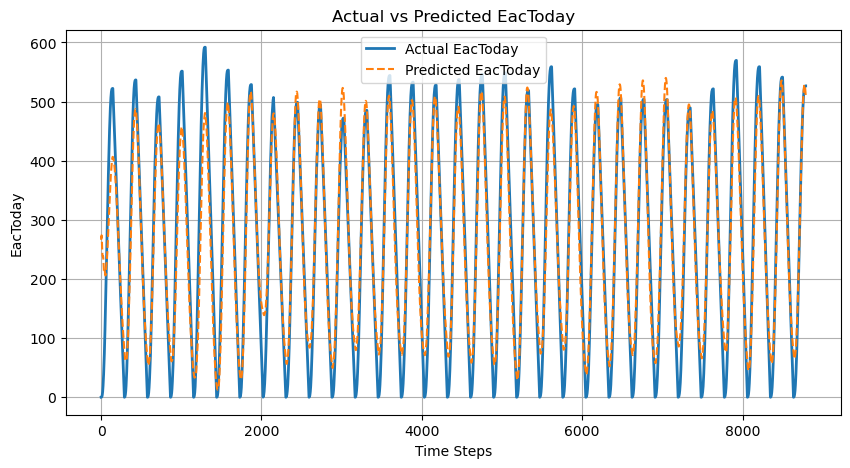

In [28]:
# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(actual, label="Actual EacToday", linewidth=2)
plt.plot(y_pred_inv, label="Predicted EacToday", linestyle='--')
plt.legend()
plt.title("Actual vs Predicted EacToday")
plt.xlabel("Time Steps")
plt.ylabel("EacToday")
plt.grid(True)
plt.show()

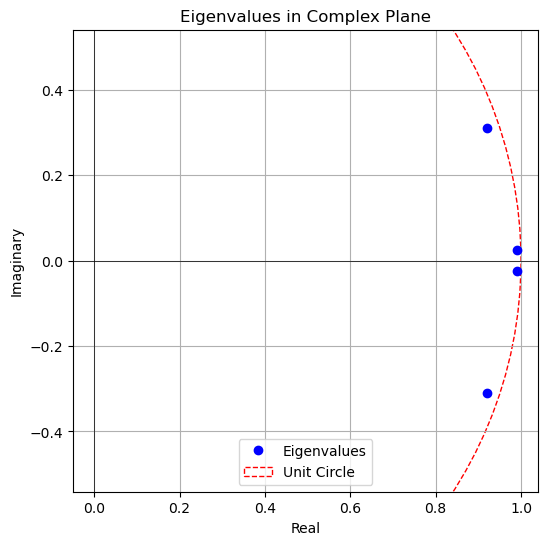

In [29]:
# Step 6: Eigen Circle (Stability check)
eng.eval("eig_vals = eig(sys.A);", nargout=0)
eig_vals = np.array(eng.workspace['eig_vals'])

plt.figure(figsize=(6, 6))
plt.plot(np.real(eig_vals), np.imag(eig_vals), 'bo', label="Eigenvalues")
circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', label='Unit Circle')
plt.gca().add_artist(circle)
plt.title("Eigenvalues in Complex Plane")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.legend()
plt.axis('equal')
plt.show()

In [30]:
eng.eval("eigvals = eig(sys.A);", nargout=0)
eigvals = np.array(eng.workspace['eigvals'])
print("System is stable:", np.all(np.abs(eigvals) < 1))

System is stable: True
